In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="JFywLBuUG8HIBagAfOmh")
project = rf.workspace("fixed-dataset").project("animal-recognition-2xjbx")
version = project.version(4)
dataset = version.download("yolov8")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 33.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 75.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 78.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigque


Extracting Dataset Version Zip to Animal-Recognition-4 in yolov8:: 100%|██████████| 17034/17034 [00:02<00:00, 6549.33it/s] 


# Check GPU Availability

In [2]:
!nvidia-smi

Tue Jul 15 09:10:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import Required Libraries

In [3]:
# Basic utilities
import os
import yaml
import cv2
import random
from pathlib import Path
from glob import glob
from collections import Counter

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


# Dataset Analysis

In [4]:
# Load data.yaml
yaml_path = Path("/kaggle/working/Animal-Recognition-4/data.yaml")  # 🔁 Update this if needed
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']
num_classes = data_yaml['nc']

train_dir = Path("/kaggle/working/Animal-Recognition-4/train/images")
val_dir   = Path("/kaggle/working/Animal-Recognition-4/valid/images")
test_dir  = Path("/kaggle/working/Animal-Recognition-4/test/images")

# Display dataset info
print("Dataset Source and Structure")
print("-" * 40)
print(f"Number of Classes     : {num_classes}")
print(f"Class Names          : {class_names}")
print(f"Train Directory       : {train_dir}")
print(f"Validation Directory  : {val_dir}")
print(f"Test Directory        : {test_dir}")

Dataset Source and Structure
----------------------------------------
Number of Classes     : 10
Class Names          : ['Bird', 'Cats', 'Cow', 'Deer', 'Dog', 'Elephant', 'Giraffle', 'Person', 'Pig', 'Sheep']
Train Directory       : /kaggle/working/Animal-Recognition-4/train/images
Validation Directory  : /kaggle/working/Animal-Recognition-4/valid/images
Test Directory        : /kaggle/working/Animal-Recognition-4/test/images


In [5]:
# Count images per folder
image_exts = ('*.jpg', '*.jpeg', '*.png')
train_imgs = sum([glob(str(train_dir / ext)) for ext in image_exts], [])
val_imgs = sum([glob(str(val_dir / ext)) for ext in image_exts], [])
test_imgs = sum([glob(str(test_dir / ext)) for ext in image_exts], [])

print("\n Image Counts:")
print(f"  • Train: {len(train_imgs)}")
print(f"  • Validation: {len(val_imgs)}")
print(f"  • Test: {len(test_imgs)}")


 Image Counts:
  • Train: 6814
  • Validation: 848
  • Test: 849


In [6]:
all_images = train_imgs + val_imgs + test_imgs

# 3b. Report total
print(f"\n Total images across all splits: {len(all_images)}")


 Total images across all splits: 8511


Glyph 128202 (\N{BAR CHART}) missing from current font.
Glyph 128202 (\N{BAR CHART}) missing from current font.


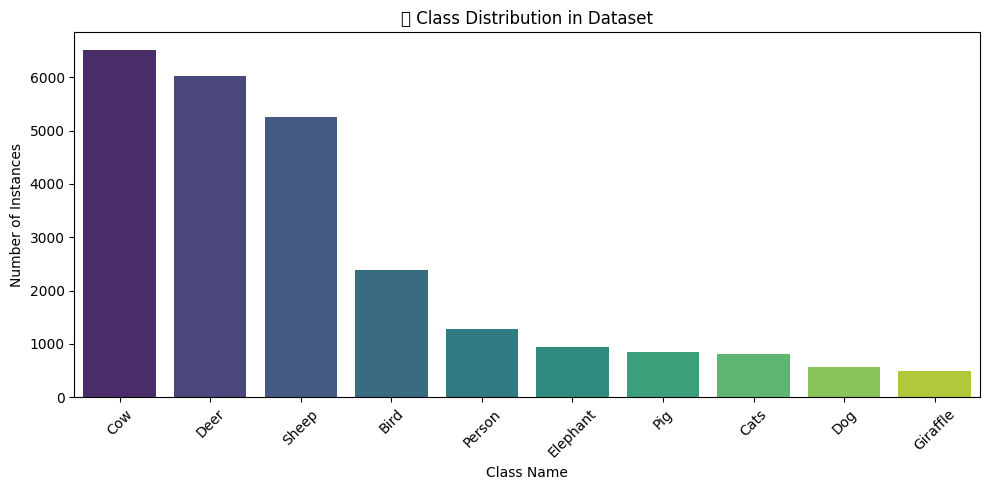

In [7]:
# Define label directories (change "images" to "labels" in paths)
train_labels_dir = Path(str(train_dir).replace("images", "labels"))
val_labels_dir   = Path(str(val_dir).replace("images", "labels"))

# Get all label files
label_files = glob(str(train_labels_dir / "*.txt")) + glob(str(val_labels_dir / "*.txt"))

# Count class occurrences
class_counter = Counter()

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id = line.strip().split()[0]
            class_counter[int(class_id)] += 1

class_df = pd.DataFrame({
    "Class Name": [class_names[i] for i in class_counter.keys()],
    "Count": list(class_counter.values())
}).sort_values(by="Count", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=class_df, x="Class Name", y="Count", palette="viridis")
plt.title("📊 Class Distribution in Dataset")
plt.xlabel("Class Name")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#  Data Augmentation

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Augmentations using Albumentations
augmentations = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=1.0)
])

def apply_and_show_aug(img_path):
    image = cv2.imread(img_path)
    if image is None:
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = augmentations(image=image_rgb)
    aug_img = augmented['image']

    # Plot original and augmented side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(image_rgb)
    axs[0].set_title("Original")
    axs[0].axis("off")
    
    axs[1].imshow(aug_img)
    axs[1].set_title("Augmented")
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()



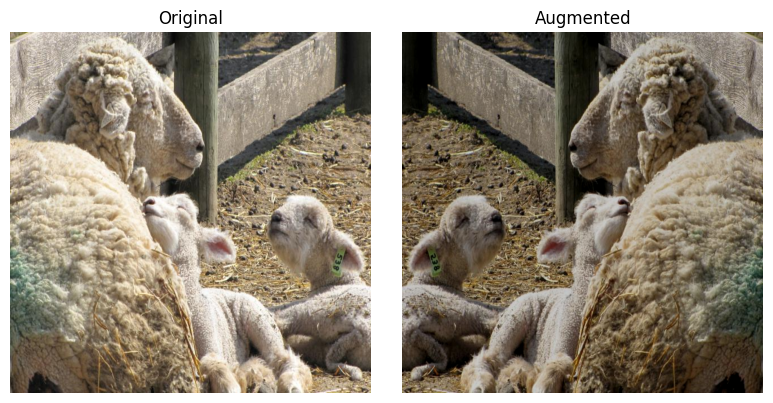

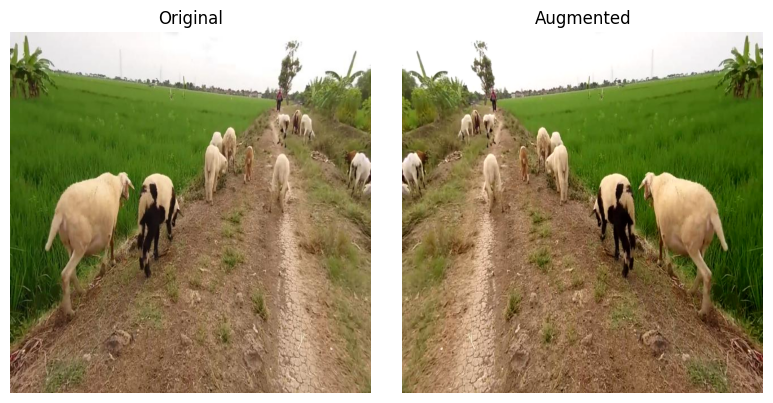

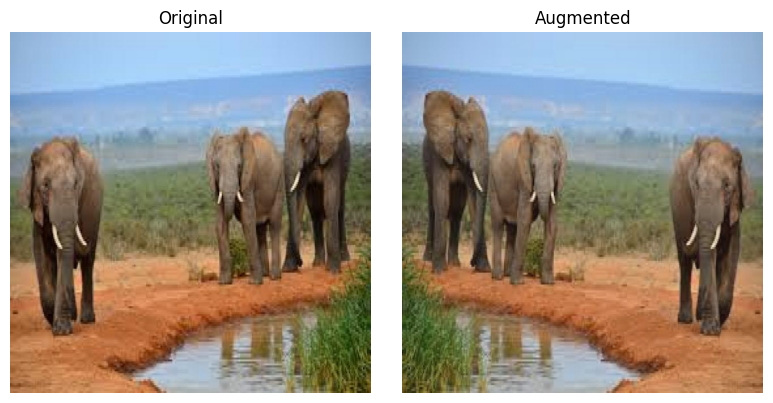

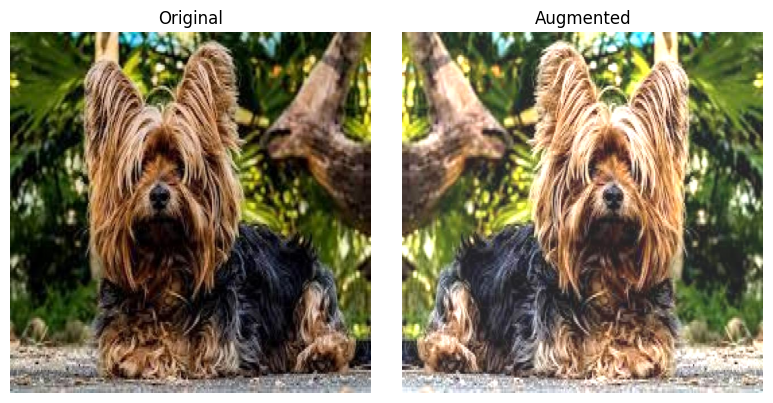

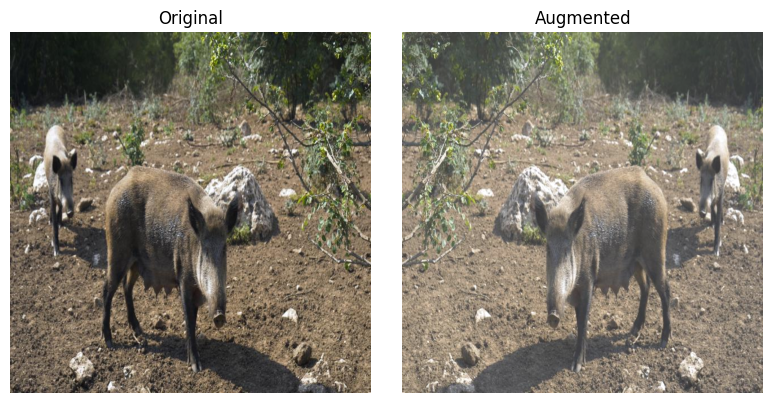

In [11]:
# Select 5 random images from dataset
if all_images:
    sample_images = random.sample(all_images, min(5, len(all_images)))
    for img in sample_images:
        apply_and_show_aug(img)
else:
    print(" No images found to perform augmentation.")

# Data Pre Processing

In [10]:
def check_image_dimensions(image_paths):
    sizes = []
    for img_path in image_paths[:100]:  # Check first 100 for speed
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append(img.shape[:2])
    return pd.Series(sizes).value_counts()

# Check typical image sizes
print("Image dimension check (Train Set):")
check_image_dimensions(glob(str(train_dir / "*.jpg")))


Image dimension check (Train Set):


(640, 640)    100
Name: count, dtype: int64

In [11]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [2]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

In [3]:
train_config = {
    "data": "/kaggle/working/Animal-Recognition-4/data.yaml",  
    "epochs": 25,                  # number of training epochs
    "imgsz": 640,                  # image size (automatically resizes)
    "batch": 16,                   # batch size (adjust based on GPU memory)
    "name": "animal-detection-yolov8",  # name of run directory
    "device": 0,                   # 0 = GPU, 'cpu' if using CPU
    "augment": True,              # enable built-in data augmentation
    "workers": 4,                 # number of dataloader workers (adjust if needed)
    "patience": 5                 # optional: early stopping if no improvement
}

model.train(**train_config)


Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Animal-Recognition-4/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=animal-detection-yolov82, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, pl

train: Scanning /kaggle/working/Animal-Recognition-4/train/labels... 6814 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6814/6814 [00:07<00:00, 941.60it/s] 

train: /kaggle/working/Animal-Recognition-4/train/images/56d0368ac0_jpg.rf.99fae5af22fb91e7f88cdee949714b3f.jpg: 1 duplicate labels removed
train: /kaggle/working/Animal-Recognition-4/train/images/639ec084da_jpg.rf.ad23b55739bbd33691d5afa01394a783.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/Animal-Recognition-4/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 18473, len(boxes) = 22898. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 557.7±330.3 MB/s, size: 56.8 KB)


val: Scanning /kaggle/working/Animal-Recognition-4/valid/labels... 848 images, 0 backgrounds, 0 corrupt: 100%|██████████| 848/848 [00:01<00:00, 571.42it/s] 

val: New cache created: /kaggle/working/Animal-Recognition-4/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1889, len(boxes) = 2263. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/animal-detection-yolov82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/animal-detection-yolov82
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       4.6G       1.13      2.041      1.299        104        640: 100%|██████████| 426/426 [01:59<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]


                   all        848       2263      0.471      0.544       0.47      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.64G      1.158      1.462      1.315         93        640: 100%|██████████| 426/426 [02:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


                   all        848       2263      0.454      0.476      0.437      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.67G      1.203      1.445       1.34         85        640: 100%|██████████| 426/426 [02:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


                   all        848       2263      0.432      0.441      0.419      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.71G      1.179      1.404       1.33         65        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


                   all        848       2263      0.497      0.567      0.517       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.74G      1.152      1.316      1.314         88        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


                   all        848       2263      0.577      0.628      0.621      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.78G      1.123      1.233      1.289         75        640: 100%|██████████| 426/426 [02:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


                   all        848       2263      0.629      0.643      0.637      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.82G      1.087      1.165      1.278         68        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.22it/s]

                   all        848       2263      0.653      0.676      0.696      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.85G      1.062      1.125      1.257         83        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

                   all        848       2263       0.68      0.666        0.7      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.89G      1.035      1.088      1.243         63        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

                   all        848       2263      0.706      0.694      0.723      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.93G      1.011       1.04      1.231        102        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.22it/s]

                   all        848       2263       0.72      0.695      0.735      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.96G     0.9961      1.013       1.22         54        640: 100%|██████████| 426/426 [02:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

                   all        848       2263      0.704      0.683      0.723      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         5G     0.9787     0.9769      1.208        130        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


                   all        848       2263      0.723      0.748      0.779      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.04G     0.9556     0.9396      1.195         63        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.28it/s]

                   all        848       2263      0.763      0.692      0.774      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.07G     0.9424     0.9154      1.185         53        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


                   all        848       2263      0.722       0.77        0.8      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.11G     0.9347     0.8826      1.182         94        640: 100%|██████████| 426/426 [02:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


                   all        848       2263      0.786      0.765      0.825        0.6
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.14G      0.863     0.7586      1.144         56        640: 100%|██████████| 426/426 [02:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

                   all        848       2263      0.794      0.752      0.828      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.18G     0.8238     0.7033       1.12         30        640: 100%|██████████| 426/426 [02:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]

                   all        848       2263      0.766       0.77      0.824      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.22G      0.807     0.6772       1.11         19        640: 100%|██████████| 426/426 [02:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]

                   all        848       2263      0.806      0.759       0.84      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.25G     0.7888     0.6523      1.101         48        640: 100%|██████████| 426/426 [02:02<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.29it/s]

                   all        848       2263      0.822      0.788      0.849      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.66G     0.7728     0.6247       1.09         39        640: 100%|██████████| 426/426 [02:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

                   all        848       2263      0.808      0.808      0.857      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       5.7G     0.7573     0.6143      1.075         61        640: 100%|██████████| 426/426 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.30it/s]

                   all        848       2263       0.83      0.796       0.87      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.73G     0.7345     0.5863       1.07         46        640: 100%|██████████| 426/426 [02:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.31it/s]

                   all        848       2263      0.839      0.803      0.864      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.77G     0.7208     0.5597      1.057         25        640: 100%|██████████| 426/426 [02:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.28it/s]

                   all        848       2263       0.85      0.771      0.872      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       5.8G     0.7066      0.545      1.048         39        640: 100%|██████████| 426/426 [02:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.28it/s]

                   all        848       2263       0.81      0.851      0.892      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.84G     0.6953     0.5297      1.035         29        640: 100%|██████████| 426/426 [02:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.26it/s]

                   all        848       2263       0.81      0.837      0.889      0.699



25 epochs completed in 0.914 hours.
Optimizer stripped from runs/detect/animal-detection-yolov82/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/animal-detection-yolov82/weights/best.pt, 22.5MB

Validating runs/detect/animal-detection-yolov82/weights/best.pt...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:15<00:00,  1.71it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        848       2263      0.839      0.838      0.895      0.717
                  Bird          5          6       0.85          1      0.995      0.648
                   Cow         37         95      0.786      0.736        0.8      0.693
                  Deer         38         68      0.766      0.868      0.904      0.797
                   Dog        123        142       0.83      0.817      0.857      0.648
              Elephant        119        219      0.923      0.817      0.937      0.638
              Giraffle         79        117      0.929      0.895      0.946      0.841
                Person         84        132      0.795      0.818      0.871      0.684
                   Pig        105        185      0.853      0.914      0.932      0.859
                 Sheep        319       1299      0.819      0.674      0.808      0.644
Speed: 0.2ms preprocess, 14.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d4b3d9f47d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

# Evaluate on Validation Set & Gather Metrics

In [4]:
# Cell 5 — Evaluate on Validation Set & Gather Metrics

import pandas as pd  # ensure pandas is available

# 1. Run validation on your val split
results = model.val(
    data=train_config["data"],
    imgsz=train_config["imgsz"],
    batch=train_config["batch"],
    workers=train_config["workers"]
)

metrics = results.box  # the Metric object

# 2. Unpack overall metrics (mp, mr, map50, map) and convert to percentages
mp, mr, map50, mAP = metrics.mean_results()
overall = {
    "Precision (%)":    mp   * 100,
    "Recall (%)":       mr   * 100,
    "mAP@0.5 (%)":      map50 * 100,
    "mAP@0.5:0.95 (%)": mAP  * 100,
}

df_overall = pd.DataFrame.from_dict(overall, orient="index", columns=["Value"])
print("=== Overall Detection Metrics ===")
display(df_overall.style.format("{:.2f}"))


Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1292.6±697.9 MB/s, size: 56.1 KB)


val: Scanning /kaggle/working/Animal-Recognition-4/valid/labels.cache... 848 images, 0 backgrounds, 0 corrupt: 100%|██████████| 848/848 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1889, len(boxes) = 2263. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:27<00:00,  1.90it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        848       2263       0.84      0.836      0.894      0.718
                  Bird          5          6      0.854          1      0.995      0.657
                   Cow         37         95      0.786      0.734        0.8      0.694
                  Deer         38         68      0.765      0.868      0.905      0.795
                   Dog        123        142      0.832      0.817      0.857      0.651
              Elephant        119        219      0.922      0.813      0.937      0.638
              Giraffle         79        117      0.929      0.891      0.945      0.839
                Person         84        132      0.798      0.818      0.871      0.686
                   Pig        105        185      0.853      0.914      0.932      0.858
                 Sheep        319       1299      0.818      0.666      0.808      0.644
Speed: 0.5ms preprocess, 28.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detec

#  Per‑Class Breakdown

In [5]:
# metrics object
metrics = results.box  
class_names = [results.names[i] for i in sorted(results.names.keys())][: len(metrics.p)]

# Build the DataFrame
per_class = pd.DataFrame({
    "Precision (%)":    [x * 100 for x in metrics.p],
    "Recall (%)":       [x * 100 for x in metrics.r],
    "mAP@0.5 (%)":      [x * 100 for x in metrics.ap50],
    "mAP@0.5:0.95 (%)": [x * 100 for x in metrics.ap],
}, index=class_names)

print("=== Per‑Class Metrics ===")
display(per_class.style.format("{:.2f}"))


=== Per‑Class Metrics ===


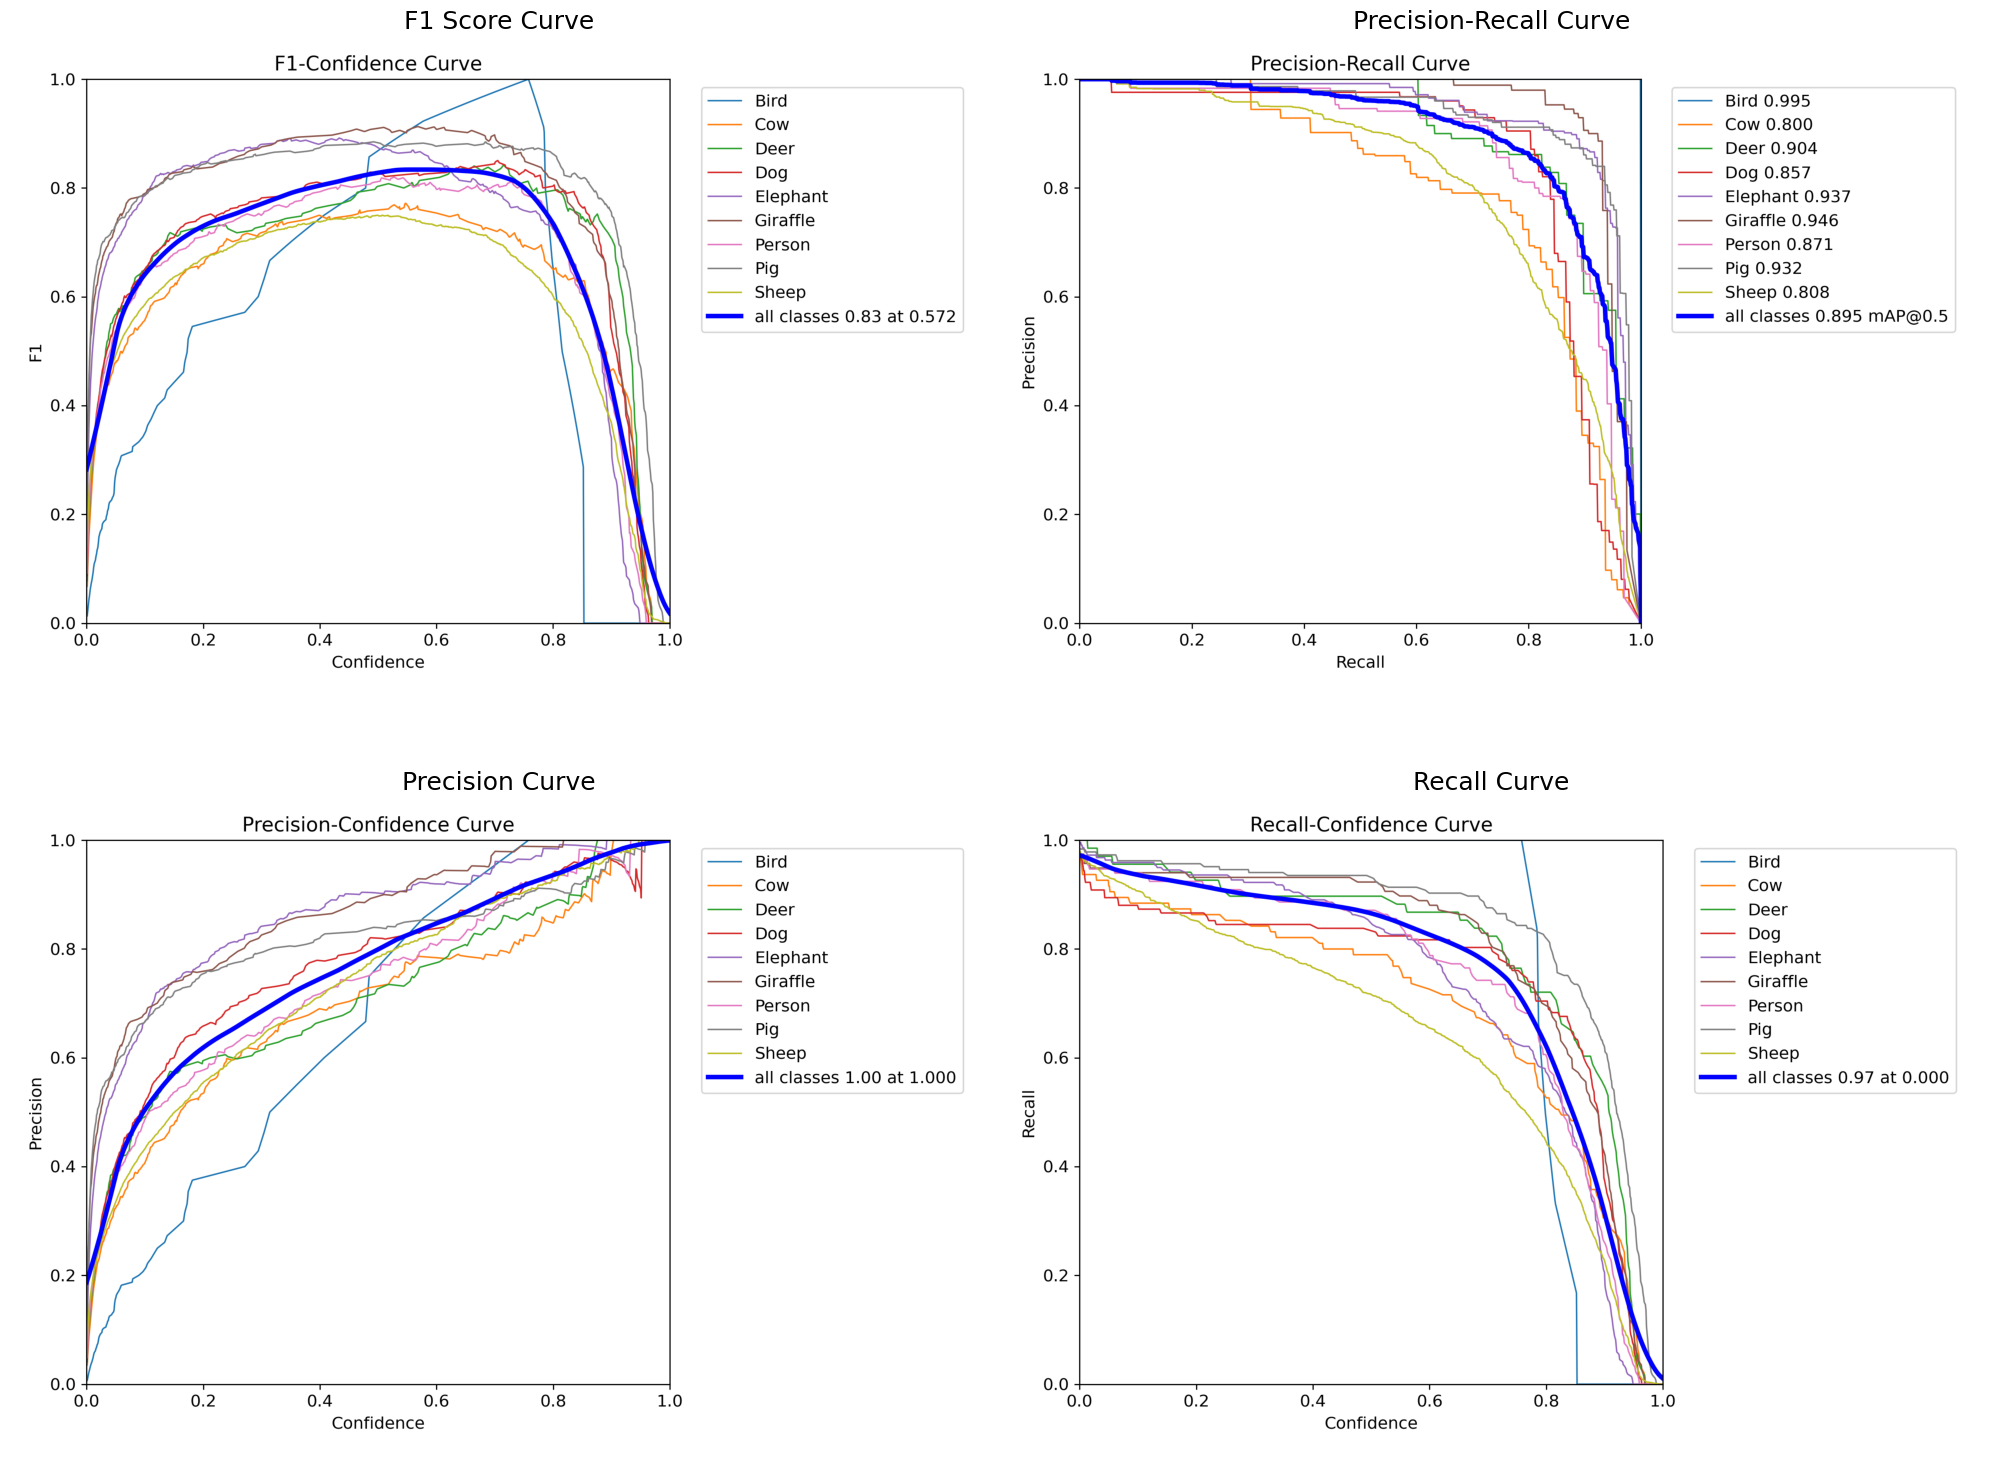

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Update this if your run name is different
run_dir = Path("/kaggle/working/runs/detect/animal-detection-yolov82")

# Define image paths and titles
images = [
    run_dir / "BoxF1_curve.png",
    run_dir / "BoxPR_curve.png",
    run_dir / "BoxP_curve.png",
    run_dir / "BoxR_curve.png"
]

titles = ['F1 Score Curve', 'Precision-Recall Curve', 'Precision Curve', 'Recall Curve']

# Plot all results in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

for i, img_path in enumerate(images):
    if img_path.exists():
        img = mpimg.imread(str(img_path))
        ax = axs[i // 2, i % 2]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(titles[i], fontsize=18)
    else:
        print(f" Image not found: {img_path}")

plt.tight_layout()
plt.show()


In [ ]:
from ultralytics import YOLO
model = YOLO("/kaggle/working/runs/detect/animal-detection-yolov82/weights/best.pt")


image 1/1 /kaggle/working/Animal-Recognition-4/valid/images/074162b10146d3b5_jpg.rf.e50aa83046a26a04d4ce8ce6391a2152.jpg: 640x640 1 Sheep, 98.1ms
Speed: 1.9ms preprocess, 98.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


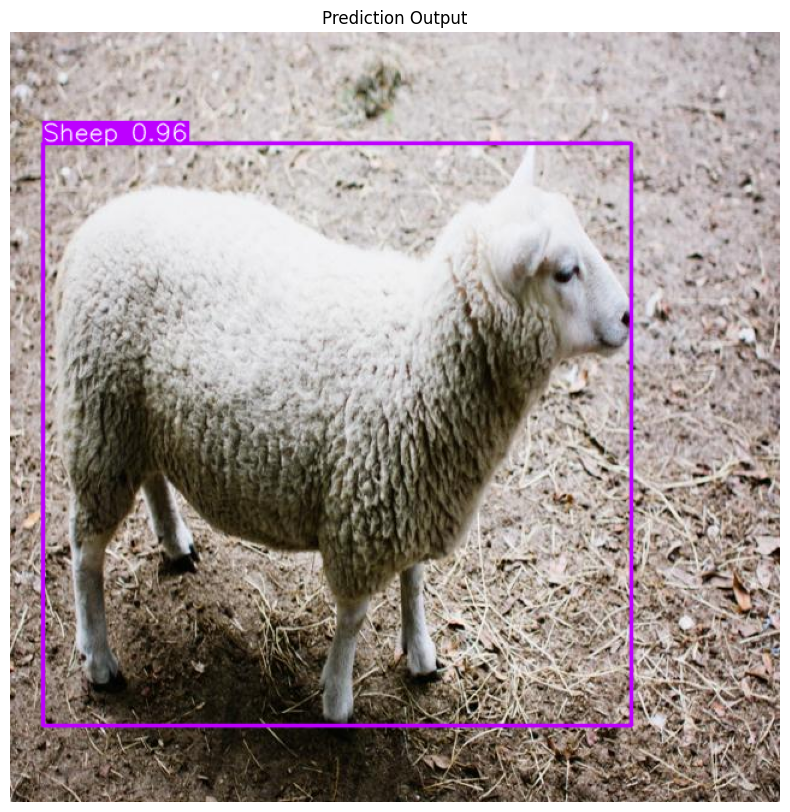

In [8]:
import cv2
import matplotlib.pyplot as plt

def run_inference(image_path):
    # Run prediction
    results = model(image_path)

    img_with_boxes = results[0].plot()  

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Prediction Output")
    plt.show()

static_image_path = "/kaggle/working/Animal-Recognition-4/valid/images/074162b10146d3b5_jpg.rf.e50aa83046a26a04d4ce8ce6391a2152.jpg"
run_inference(static_image_path)



image 1/1 /kaggle/working/Animal-Recognition-4/valid/images/107_jpeg.rf.6fa7b917cb5627e6f97e2acadfb21403.jpg: 640x640 1 Dog, 43.9ms
Speed: 1.9ms preprocess, 43.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


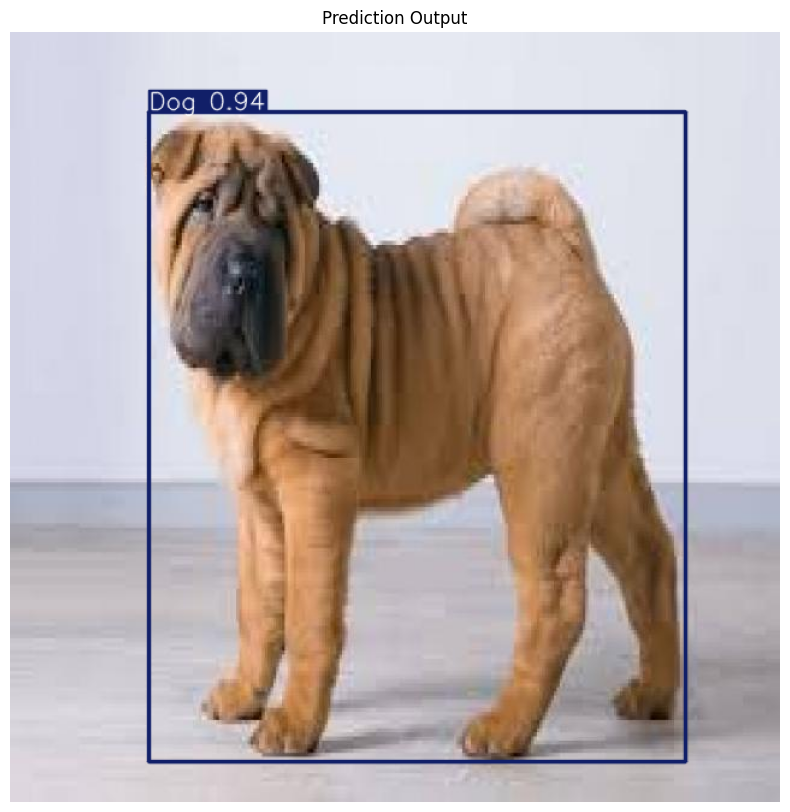

In [9]:
import cv2
import matplotlib.pyplot as plt

def run_inference(image_path):
    # Run prediction
    results = model(image_path)

    img_with_boxes = results[0].plot()  

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Prediction Output")
    plt.show()

static_image_path = "/kaggle/working/Animal-Recognition-4/valid/images/107_jpeg.rf.6fa7b917cb5627e6f97e2acadfb21403.jpg"
run_inference(static_image_path)
